# Index
<ol>
    <li><a href="#h1_1">Problem Setting: Maze Solving</a>
        <ol>
            <li><a href="#h1_1__h2_1">Problem Solution: Epsilon-Greedy Q-Learning</a></li>
            <li><a href="#h1_1__h2_2">Problem Solution: Q-Learning, loosely coupled with Deep Boltzmann Machine.</a></li>
        </ol>
    </li>
</ol>    

# Problem Setting: Maze Solving
<a name="h1_1"></a>
This notebook demonstrates a simple maze solving algorithm based on Q-Learning. First of all, the maze map must be generated. The following is an example of map. 

This algorithm allow the agent to search the goal in 2D maze map. The agent can search and learn by the reward values in each point.

In relation to reinforcement learning theory, the state of agent is 2D position coordinates and the action is to dicide the direction of movement. Within the wall, the agent is movable in a cross direction and can advance by one point at a time. After moving into a new position, the agent can obtain a reward. On greedy searching, this extrinsically motivated agent performs in order to obtain some reward as high as possible. Each reward value is plot in map.

The map data that agent will observe is as follow.

$$\boldsymbol{M}_{reward} =
\begin{pmatrix}
r_{1,1} & \cdots & r_{1,j} & \cdots & r_{1,m} \\
\vdots & \ddots &        &        & \vdots \\
r_{i,1} &        & r_{i,j} & \cdots & r_{i,m} \\
\vdots &        &        & \ddots & \vdots \\
r_{n,1} & \cdots & r_{n,j} & \cdots & r_{n,m}
\end{pmatrix}
$$

where $(i, j)$ is tuple of 2D position coordinates in the maze map. Then $r_{i,j}$ is reward value that the agent can get by arriving the point: $(i, j)$. The state of agent is $s_{i,j}$. In this case, the form of agent's state transition matrix is designed to correspond with $\boldsymbol{M}_{reward}$ as follow.

$$\boldsymbol{M}_{state} =
\begin{pmatrix}
s_{1,1} & \cdots & s_{1,j} & \cdots & s_{1,m} \\
\vdots & \ddots &        &        & \vdots \\
s_{i,1} &        & s_{i,j} & \cdots & s_{i,m} \\
\vdots &        &        & \ddots & \vdots \\
s_{n,1} & \cdots & s_{n,j} & \cdots & s_{n,m}
\end{pmatrix}
$$

The possible actions of agent can be limited by $s_{i,j}$. Agent can select adjacent elements in $\boldsymbol{M}_{state}$.

So in this problem setting, the maze map data can be as generated below in detail.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# The number of records.
map_row = 25
# The number of columns.
map_col = 25

# `#` is wall in maze.
# `S` is a start point.
# `G` is a goal.
# `@` is the agent.
start_point_label, end_point_label, wall_label, agent_label = ("S", "G", "#", "@")

In [3]:
# The reward values can be generated by random sampling.
real_map_arr = np.random.normal(5, 2, size=(map_row, map_col))
real_map_arr = np.round(real_map_arr, 1)

map_arr = real_map_arr.astype(object)

# For visualization.
real_map_arr = map_arr[1:map_row-1, 1:map_row-1]
real_map_arr = real_map_arr.astype(np.float64)

# For learning.
map_arr[:, 0] = wall_label
map_arr[0, :] = wall_label
map_arr[-1, :] = wall_label
map_arr[:, -1] = wall_label
map_arr[map_row-2, map_col-2] = end_point_label
map_arr[1, 1] = start_point_label

In [4]:
# The start point.
real_map_arr[0, 0] = -1.0
# The end point(Goal).
real_map_arr[map_row-3, map_col-3] = -1.0

In [5]:
map_arr

array([['#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
        '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#'],
       ['#', 'S', 3.1, 2.2, 2.9, 5.9, 2.9, 3.3, 7.4, 4.6, 3.9, 5.6, 7.2,
        6.7, 4.7, 6.1, 4.4, 8.6, 4.5, 4.4, 1.4, 4.2, 4.2, 4.9, '#'],
       ['#', 4.6, 6.8, 5.5, 4.4, 3.6, 3.3, 8.2, 2.1, 3.2, 4.7, 1.7, 6.2,
        6.5, 6.9, 6.0, 5.8, 4.6, 7.1, 6.6, 7.6, 1.8, 3.3, 4.1, '#'],
       ['#', 6.4, 5.1, 5.3, 1.4, 3.6, 6.9, 7.8, 4.5, 2.9, 5.0, 5.8, 2.2,
        2.6, 5.0, 6.2, 6.3, 2.5, 7.7, 8.5, 8.7, 4.8, 5.0, 4.5, '#'],
       ['#', 6.1, 6.1, 3.2, 3.2, 5.6, 6.2, 8.1, 4.7, 4.6, 2.0, 6.3, 8.0,
        4.8, 8.2, 0.9, 4.9, 7.0, 4.5, 9.9, 6.9, 2.4, 8.3, 5.8, '#'],
       ['#', 4.0, 6.9, 6.9, 4.2, 2.9, -0.2, 3.2, 3.8, 4.5, 4.9, 3.9, 2.5,
        7.0, 5.9, 5.2, 6.1, 6.6, 6.9, 3.2, 6.1, 1.1, 1.2, 3.3, '#'],
       ['#', 0.7, 4.1, 3.8, 5.4, 4.9, 4.6, 3.5, 1.5, 5.6, 4.3, 6.8, 3.8,
        7.0, 4.9, 2.9, 3.9, 4.5, 8.3, 4.8, 3.9, 6.8, 8.9, 4.1, '#'],
     

The reward values in the map data can be visualized as follow. The map has the X axis horizontal and the Y axisvertical with the origin [0, 0] at the upper-left corner. The coordinates of goal is [23, 23].

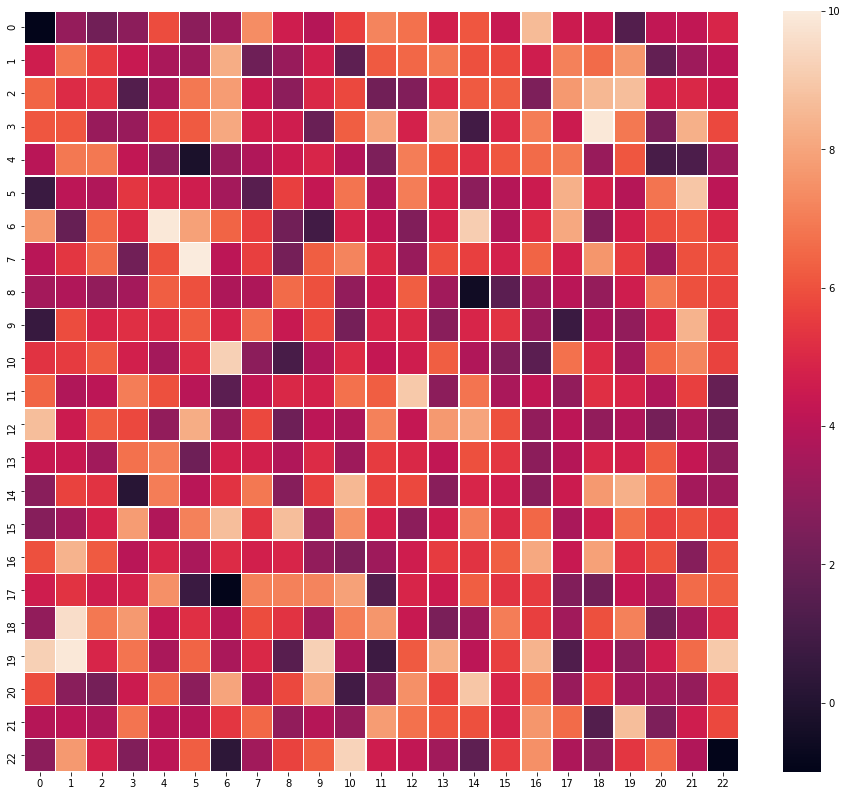

In [6]:
fig = plt.figure(figsize=(16, 14))
sns.heatmap(real_map_arr, linewidths=.5)
plt.show();plt.close()

<a name="h1_1__h2_1"></a>
## Problem Solution: Epsilon Greedy Q-Learning

In this prototyping, we can select the Epsilon Greedy Q-Learning as the problem solution.

Q-Learning is a kind of Temporal Difference learning(TD Learning) that can be considered as hybrid of Monte Carlo method and Dynamic Programming Method. As Monte Carlo method, TD Learning algorithm can learn by experience without model of environment. And this learning algorithm is functionally equivalent of bootstrap method as Dynamic Programming Method.

Epsilon Greedy Q-Leanring algorithm is `off-policy`. In this paradigm, stochastic searching and deterministic searching can coexist by hyperparameter $\epsilon (0 < \epsilon < 1)$ that is probability that agent searches greedy. Greedy searching is deterministic in the sense that policy of agent follows the selection that maximizes the Q-Value.

### Design and Implementation

`MazeGreedyQLearning` in [demo_maze_greedy_q_learning.py](https://github.com/chimera0/accel-brain-code/blob/master/Reinforcement-Learning/demo/demo_maze_greedy_q_learning.py) is a Concrete Class in `Template Method Pattern` to run the Q-Learning algorithm for this task. `GreedyQLearning` in [../pyqlearning/qlearning/greedy_q_learning.py](https://github.com/chimera0/accel-brain-code/blob/master/Reinforcement-Learning/pyqlearning/qlearning/greedy_q_learning.py) is also Concreat Class for the epsilon-greedy-method. The Abstract Class that defines the skeleton of Q-Learning algorithm in the operation and declares algorithm placeholders is [../pyqlearning/q_learning.py](https://github.com/chimera0/accel-brain-code/blob/master/Reinforcement-Learning/demo_maze_greedy_q_learning.py). So the following program is a kind of Client in `Template Method Pattern`.

In [7]:
from demo_maze_greedy_q_learning import MazeGreedyQLearning


class iPyMazeGreedyQLearning(MazeGreedyQLearning):
    def visualize_learning_result(self, state_key):
        '''
        Visualize learning result.
        
        Override.
        '''
        # Default function of this method is to print the maze searched by agent.
        # But it is not important for Jupyter notebook users in this prototype.
        # Jupyter notebook allow users to create beautiful visualizations.

        #Then,
        pass


### Parameters Setting

In [8]:
# Learning(searching) count
limit = 10000
# Alpha value in Q-Learning.
alpha_value = 0.9
# Gamma value in Q-Learning.
gamma_value = 0.9
# Epsilon-Greedy rate in Epsilon-Greedy-Q-Learning.
greedy_rate = 0.75

In [9]:
# Instantiation.
maze_q_learning = iPyMazeGreedyQLearning()
# Set the parameters.
maze_q_learning.epsilon_greedy_rate = greedy_rate
maze_q_learning.alpha_value = alpha_value
maze_q_learning.gamma_value = gamma_value

# Setup.
maze_q_learning.initialize(
    map_arr=map_arr,
    start_point_label=start_point_label,
    end_point_label=end_point_label,
    wall_label=wall_label,
    agent_label=agent_label
)

### Searching and Learning

In [10]:
# Learning.
maze_q_learning.learn(state_key=(1, 1), limit=limit)

In [11]:
q_df = pd.DataFrame(np.c_[np.array(maze_q_learning.q_df.action_key.values.tolist()), maze_q_learning.q_df["q_value"].values], columns=["x", "y", "q_value"])
q_df = q_df.sort_values(by=["q_value"], ascending=False)
q_df = q_df.drop_duplicates(["x", "y"])

### Learned Q(s, a)

The agent has tried to search the optimal route and learn the Q(s, a) but did not arrived at the goal. As shown in bellow map image, it can be proved by the fact that there are no Q-value in the neighborhood of the goal.

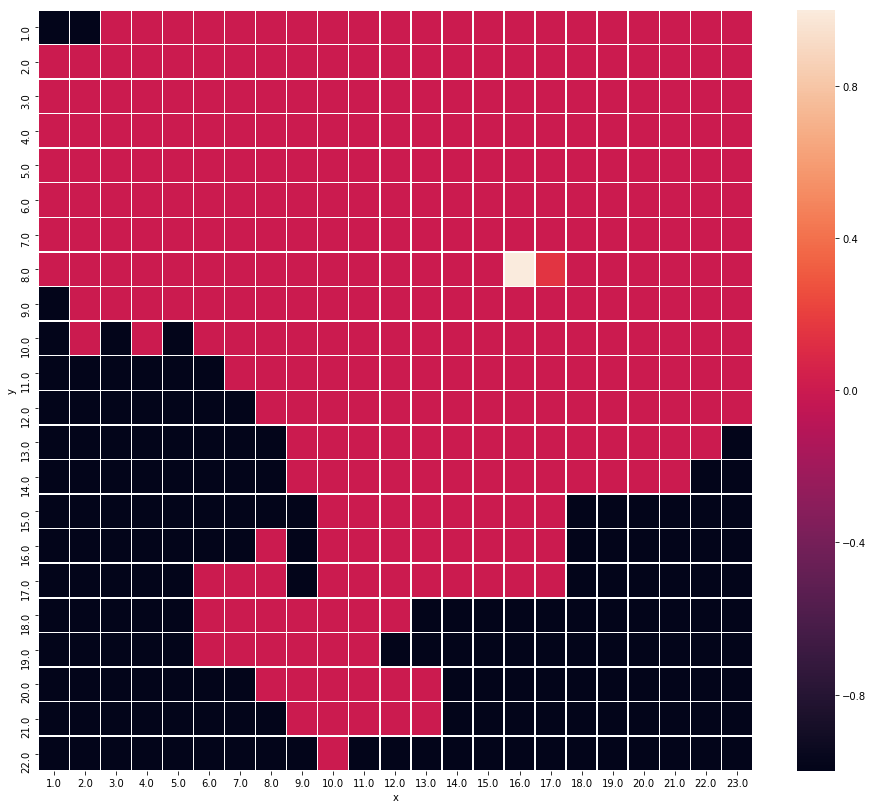

In [12]:
fig = plt.figure(figsize=(16, 14))
sns.heatmap(
    q_df.pivot(columns="x", index="y", values="q_value").fillna(-1),
    linewidths=.5
)
plt.show();plt.close()

### Inference an optimal route in this maze map.

For a while, let's inference the optimal route.

In [13]:
# Inference an optimal route in this maze map by Q-values.
inferenced_result_list = maze_q_learning.inference(limit=10000)

In [14]:
# Re-format.
result_df = pd.DataFrame(np.array(inferenced_result_list), columns=["x", "y", "q_value"])

### Visualization of the optimum route

Because of failed to search and learn, the agent can not inference route to the goal. 

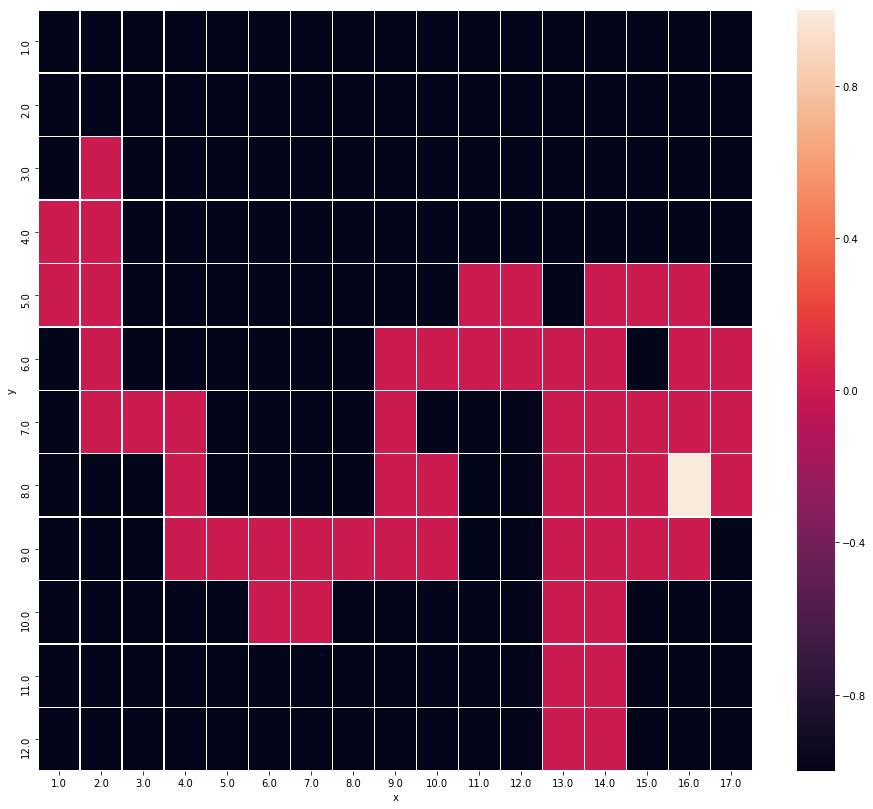

In [15]:
fig = plt.figure(figsize=(16, 14))
sns.heatmap(
    result_df.drop_duplicates(["x", "y"]).pivot(columns="x", index="y", values="q_value").fillna(-1),
    linewidths=.5
)
plt.show();plt.close()

<a name="h1_1__h2_2"></a>
## Problem Solution: Q-Learning, loosely coupled with Deep Boltzmann Machine.

In this demonstration, let me cite the Q-Learning, loosely coupled with Deep Boltzmann Machine (DBM). As API Documentation of [pydbm](https://github.com/chimera0/accel-brain-code/tree/master/Deep-Learning-by-means-of-Design-Pattern) library has pointed out, DBM is functionally equivalent to stacked auto-encoder. The main function I observe is the same as dimensions reduction(or pre-training). Then the function of this DBM is dimensionality reduction of reward value matrix.

Q-Learning, loosely coupled with Deep Boltzmann Machine (DBM), is a more effective way to solve maze. The pre-training by DBM allow Q-Learning agent to abstract feature of reward value matrix and to observe the map in a bird's-eye view. Then agent can reach the goal with a smaller number of trials.

### Feature engineering and Feature extraction

For instance, the following is a matrix of so-called observed data points in DBM learning. $\boldsymbol{M}_{feature}$ can have compositions corresponding to $\boldsymbol{M}_{reward}$ as follow.

$$\boldsymbol{M}_{feature} = 
\begin{pmatrix}
f_{1,1} & \cdots & f_{1,i} & \cdots & f_{1,m} \\
\vdots & \ddots &        &        & \vdots \\
f_{i,1} &        & f_{i,j} & \cdots & f_{i,m} \\
\vdots &        &        & \ddots & \vdots \\
f_{n,1} & \cdots & f_{n,j} & \cdots & f_{n,m}
\end{pmatrix}
$$

where $f_{i,j}$ is the feature point corresponding to $r_{i,j}$ in $\boldsymbol{M}_{reward}$. The form of observed data point $\boldsymbol{D}_{ij}$ as follow.

$$\boldsymbol{D}_{i, j} = \begin{pmatrix}
r_{i-5,j-5}\\
r_{i-4,j-5}\\
\vdots \\
r_{i-5,j-5}\\
r_{i-4,j-4}\\
\vdots \\
r_{i,j}\\
r_{i+1,j}\\
\vdots \\
r_{i,j+1}\\
\vdots \\
f_{i+5,j+5}
\end{pmatrix}$$

And $\boldsymbol{D}_{ij}$ can be transformed by function of DBM: $\mathcal{F}_{DBM}$.

$$f_{i,j} = \mathcal{F}_{DBM}(\boldsymbol{D}_{i,j})$$

Then the feature representation can be as calculated below.

### Implementation

In [16]:
from pydbm.dbm.deepboltzmannmachine.stacked_auto_encoder import StackedAutoEncoder
from pydbm.dbm.builders.dbm_multi_layer_builder import DBMMultiLayerBuilder
from pydbm.approximation.contrastive_divergence import ContrastiveDivergence
from pydbm.activation.softmax_function import SoftmaxFunction
from pydbm.activation.relu_function import ReLuFunction
from pydbm.activation.logistic_function import LogisticFunction

In [52]:
 vector_list_list = []
for y in range(real_map_arr.shape[0]):
    for x in range(real_map_arr.shape[1]):
        vector_list = []
        vector_list.append(real_map_arr[y, x])
        for _x in range(-5, 5):
            __x = x + _x
            for _y in range(-5, 5):
                __y = y + _y
                if __x < 0 or __y < 0:
                    vector = 0
                else:
                    try:
                        vector = real_map_arr[__y, __x]
                    except IndexError:
                        vector = 0
                vector_list.append(vector)
        vector_list_list.append(vector_list)
vector_arr = np.array(vector_list_list)
vector_arr = vector_arr.astype(float)

### Parameters setting

In [110]:
dbm = StackedAutoEncoder(
    DBMMultiLayerBuilder(),
    [vector_arr.shape[1], 10, vector_arr.shape[1]],
    [LogisticFunction(normalize_flag=True), LogisticFunction(normalize_flag=True), LogisticFunction(normalize_flag=True)],
    [ContrastiveDivergence(), ContrastiveDivergence()],
    0.001,
    0.5
)
#_vector_arr = (vector_arr - vector_arr.mean()) / vector_arr.std()
dbm.learn(
    vector_arr,
    traning_count=2,
    batch_size=10,
    r_batch_size=10
)

In [111]:
feature_arr = dbm.feature_points_arr.mean(axis=1)
feature_map_arr = feature_arr.reshape(real_map_arr.shape[0], real_map_arr.shape[1])

### Feature points

The reward values in the map data can be visualized as follow.

In [112]:
feature_map_arr[:3, :]

array([[ 0.49973039,  0.49973037,  0.49973035,  0.49973037,  0.49973035,
         0.49973035,  0.49973041,  0.49973044,  0.49973037,  0.49973038,
         0.49973514,  0.4997351 ,  0.49973516,  0.49973516,  0.49973509,
         0.49973515,  0.4997352 ,  0.49973509,  0.4997351 ,  0.49973511,
         0.49973581,  0.49973591,  0.49973587],
       [ 0.49973586,  0.49973576,  0.49973591,  0.49973579,  0.4997358 ,
         0.49973579,  0.49973587,  0.4997317 ,  0.49973168,  0.49973167,
         0.49973173,  0.49973177,  0.49973167,  0.49973165,  0.49973169,
         0.49973168,  0.49973169,  0.49973661,  0.49973663,  0.49973658,
         0.49973652,  0.49973657,  0.49973664],
       [ 0.49973661,  0.4997366 ,  0.49973664,  0.49973662,  0.49973593,
         0.49973591,  0.4997359 ,  0.49973597,  0.49973587,  0.49973588,
         0.49973593,  0.49973584,  0.49973592,  0.49973589,  0.49974192,
         0.49974188,  0.49974187,  0.49974183,  0.49974193,  0.49974188,
         0.49974189,  0.4997

Q-Value become gradually high from start point [0, 0] to goal point [23, 23].

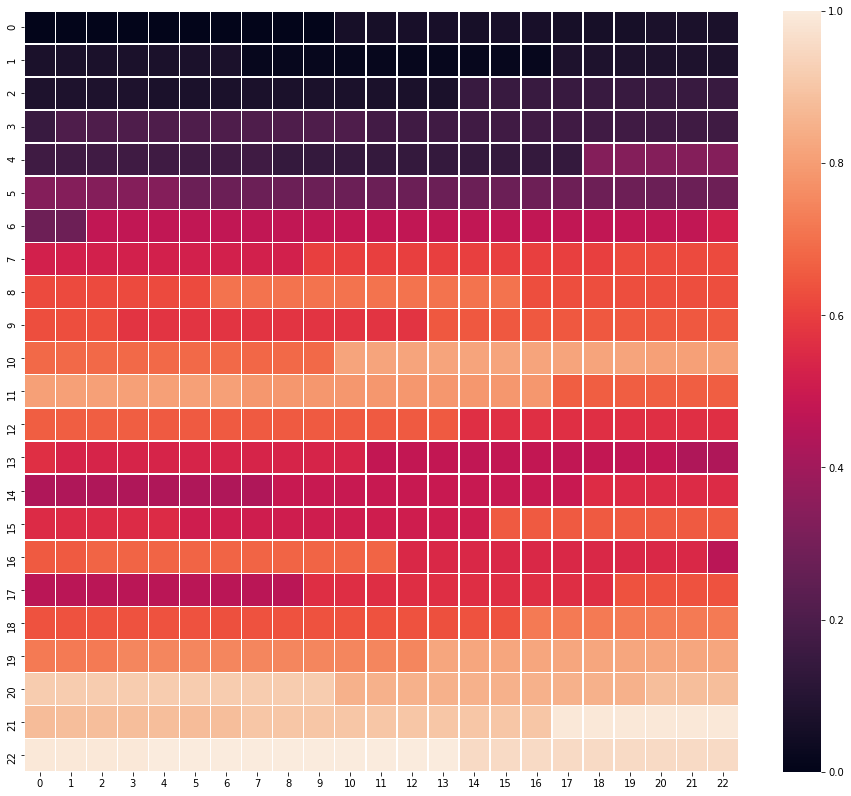

In [113]:
fig = plt.figure(figsize=(16, 14))
_feature_map_arr = (feature_map_arr - feature_map_arr.min()) / (feature_map_arr.max() - feature_map_arr.min())
sns.heatmap(_feature_map_arr, linewidths=.5)
plt.show();plt.close()

### Learning and searching

In [114]:
featured_map_arr = map_arr.copy()
featured_map_arr[1:-1, 1:-1] = _feature_map_arr

In [115]:
featured_map_arr[map_row-2, map_col-2] = end_point_label
featured_map_arr[1, 1] = start_point_label

In [116]:
# Instantiation.
maze_q_learning = iPyMazeGreedyQLearning()
# Set the parameters.
maze_q_learning.epsilon_greedy_rate = greedy_rate
maze_q_learning.alpha_value = alpha_value
maze_q_learning.gamma_value = gamma_value

# Setup.
maze_q_learning.initialize(
    map_arr=featured_map_arr,
    start_point_label=start_point_label,
    end_point_label=end_point_label,
    wall_label=wall_label,
    agent_label=agent_label
)

In [123]:
# Learning.
maze_q_learning.learn(state_key=(1, 1), limit=5000)

### Learned Q(s, a)

As shown in bellow map image, the agent arrived at the goal.

In [124]:
q_df = pd.DataFrame(np.c_[np.array(maze_q_learning.q_df.action_key.values.tolist()), maze_q_learning.q_df["q_value"].values], columns=["x", "y", "q_value"])
q_df = q_df.sort_values(by=["q_value"], ascending=False)
q_df = q_df.drop_duplicates(["x", "y"])

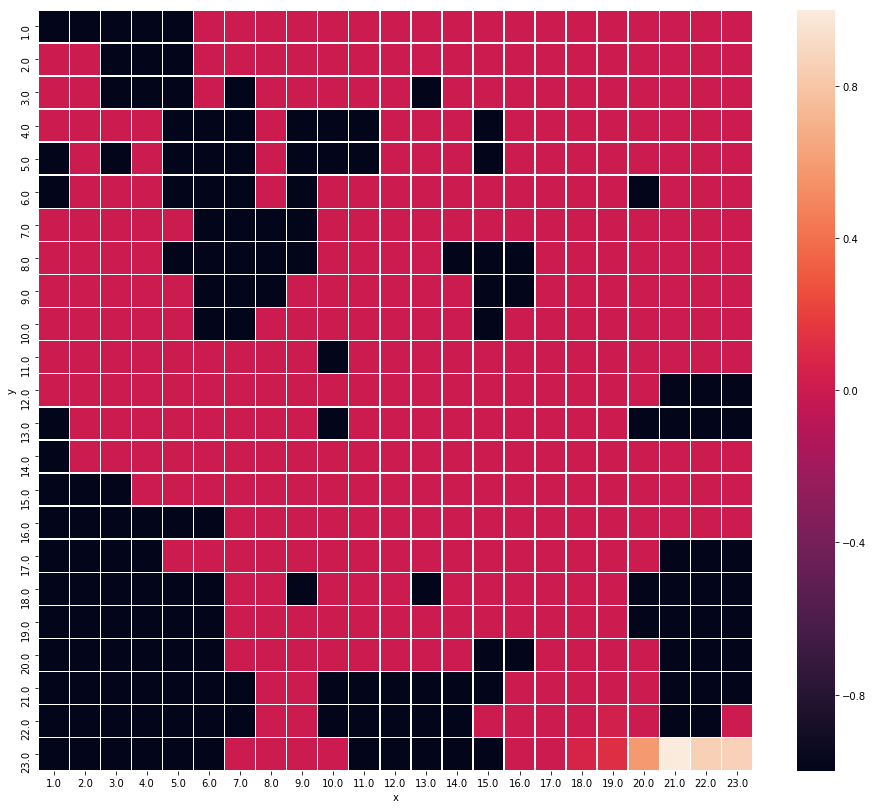

In [125]:
fig = plt.figure(figsize=(16, 14))
sns.heatmap(
    q_df.pivot(columns="x", index="y", values="q_value").fillna(-1),
    linewidths=.5
)
plt.show();plt.close()

### Inference an optimal route in this maze map.

In [141]:
# Inference an optimal route in this maze map by Q-values.
inferenced_result_list = maze_q_learning.inference(limit=15000)

In [142]:
# Re-format.
featured_result_df = pd.DataFrame(np.array(inferenced_result_list), columns=["x", "y", "q_value"])

In [145]:
featured_result_df.q_value = (featured_result_df.q_value - featured_result_df.q_value.min()) / (featured_result_df.q_value.max() - featured_result_df.q_value.min())

### Visualization of the optimum route

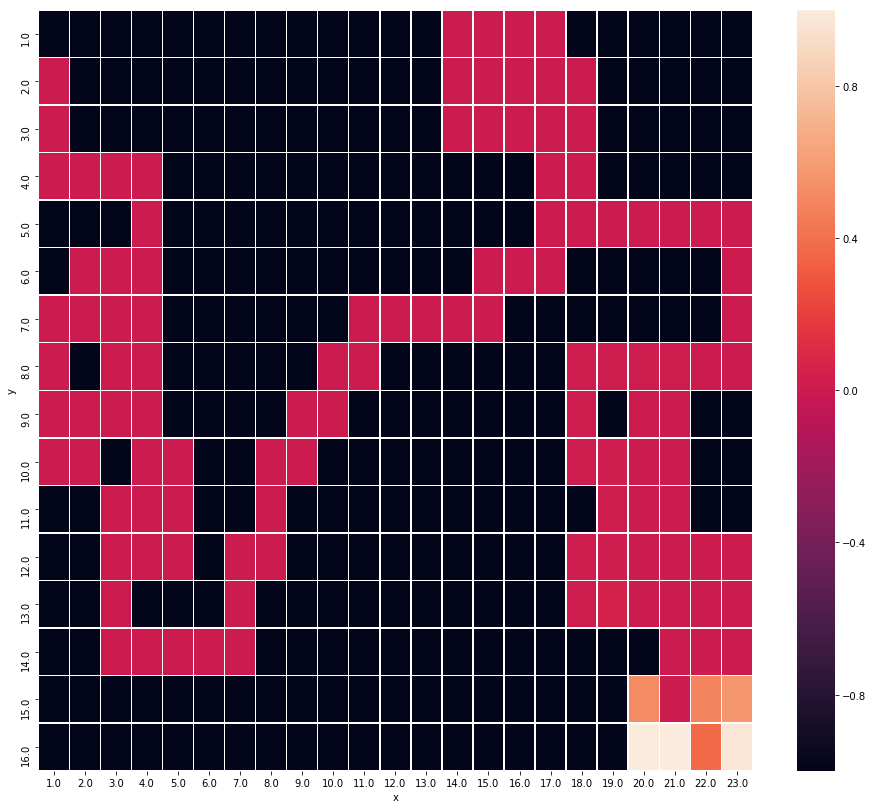

In [146]:
fig = plt.figure(figsize=(16, 14))
sns.heatmap(
    featured_result_df.drop_duplicates(["x", "y"]).pivot(columns="x", index="y", values="q_value").fillna(-1) ,
    linewidths=.5
)
plt.show();plt.close()

# References
- Sutton, R. S., & Barto, A. G. (1998). Reinforcement learning: An introduction (Vol. 1, No. 1). Cambridge: MIT press.